In [11]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Sensing/'
num_cores = -1 #number of cores for parallelization

# System parameters for periodic boundary condition spin chain
J = 1.0         # +ve is Ferromagnet [Hamiltonian as defined Mishra, Bayat, PRL 127, 080504 (2021)]
gamma = 1.0     # J(1+gamma)XX + J(1-gamma)YY (ignoring other factors, see paper or notes for defn.)
sites = 5       # system size
h1_amp = 0.2    # amplitude of the drive for periodic transverse field
h1_period = 1.0 # period of the drive for periodic transverse field
h0 = 0.1        # static transverse field

# Initial state
initial_state = 'random_state' 
# 'ground_state': starts in the system ground-state. 
# 'random_state': every site has a random up or down state

# Other options which may require some recoding for compatibility with the stroboscopic code
        # 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
        # 'momentum': a k = 0 momentum state. Even parity = PBC.
        # 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Boundary conditions
boundary_conditions = 'PBC' 
# 'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions
# The boundary conditions must reflect the fermion parity in the initial conditions (see above).
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

# Time parameters 
dt = 0.0001                         # time step for integration
oneperiod_steps = int(h1_period/dt) # number of steps in one period, make sure this is integer.
final_time = 100                     # final time in stroboscopic units (return results at stroboscopic times up to this time)

# Initialize the periodic field and its midpoint for each time-step (to be used by integration scheme)
h1 = h1_amp*np.sin(2*np.pi/(h1_period)*dt*np.arange(0,oneperiod_steps)) # initialize periodic field
h1_midpoint = h1_amp*np.sin(2*np.pi/(h1_period)*dt*(0.5 + np.arange(0,oneperiod_steps))) # vector at the mid-point between time-steps, required for RK4 due to explicit time-dependance



Calculate the eigenvalues and state of the Floquet unitary

In [ ]:
# Calculate state after 1 period starting from a basis state. This is used to build Floquet unitary.
particle_number = []
quasi_energy = []
initial_state_list = []
eval_list = []
evec_list = []

basis_state = []
for kk in range(0,sites):

    basis_state = basis_state + [np.asarray([1,0])] #basis state is up (occupied state), initial down-state used in method

method = 'RK4' # integration method 'heun' or 'RK4' (best to go for very high accuracy/small steps as only integrate 1 period.)
# integrate basis state
state = methods.integrator_BdG(J, gamma, h0, h1, h1_midpoint, oneperiod_steps, dt, sites, boundary_conditions, basis_state, method)

# Initial state is a list of vectors (u_k,v_k) 
# Build the Floquet unitary and calculate eigenvalues, eigenvectors in this basis
eval, evec = methods.floquet_eigsystem(state)

print('Eigensystem evaluated')

# Calculate the initial ground-state, replace for other initial states
if initial_state == "ground_state":

    initial_state = methods.initial_BdG(J, gamma, h0, h1, sites, boundary_conditions)

elif initial_state == "random_state":
    
    initial_state = methods.random_state(sites) # every spin random up or down

initial_state_list = initial_state_list + [initial_state]

eval_list = eval_list + [eval]
evec_list = evec_list + [evec]
eval_list = np.array(eval_list)
evec_list = np.array(evec_list)
initial_state_list = np.array(initial_state_list)
particle_number = []
sigma_Xsq = []

for time in range(0,final_time):
    print(f"time step: {time}")

    obs, Dag_obs, _ = methods.floquet_evolution_eff_vectorized(
        time,
        sites,
        boundary_conditions,
        eval_list,         # shape (1, sites, 2)
        evec_list,         # shape (1, sites, 2, 2)
        initial_state_list # shape (1, sites, 2)
    )

    # obs: shape (1, sites, sites) local observables at time t
    # Dag_obs: shape (1, sites, sites) local observables at time t

    # Z ~ particle number , <n_jj> = <c^{dag}_jj c_jj>, can also access general <c^{dag}_jj c_kk> if desired
    jj = 3 # example
    particle_number.append(obs[0, jj, jj])

    # X^2 = (c_j^dag + c_j)^2 = 1 + <c^{dag}_jj c{dag}_jj> + <c_jj c_jj>. 
    sigma_Xsq.append(1 + Dag_obs[0, jj, jj] + np.conj(Dag_obs[0, jj, jj]))


Eigensystem evaluated
time step: 0
time step: 1
time step: 2
time step: 3
time step: 4
time step: 5
time step: 6
time step: 7
time step: 8
time step: 9
time step: 10
time step: 11
time step: 12
time step: 13
time step: 14
time step: 15
time step: 16
time step: 17
time step: 18
time step: 19
time step: 20
time step: 21
time step: 22
time step: 23
time step: 24
time step: 25
time step: 26
time step: 27
time step: 28
time step: 29
time step: 30
time step: 31
time step: 32
time step: 33
time step: 34
time step: 35
time step: 36
time step: 37
time step: 38
time step: 39
time step: 40
time step: 41
time step: 42
time step: 43
time step: 44
time step: 45
time step: 46
time step: 47
time step: 48
time step: 49
time step: 50
time step: 51
time step: 52
time step: 53
time step: 54
time step: 55
time step: 56
time step: 57
time step: 58
time step: 59
time step: 60
time step: 61
time step: 62
time step: 63
time step: 64
time step: 65
time step: 66
time step: 67
time step: 68
time step: 69
time ste

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


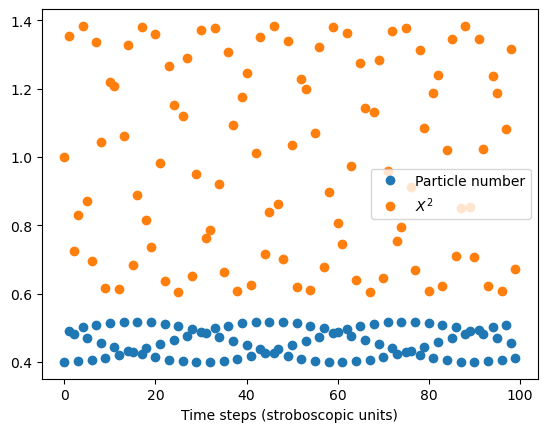

In [13]:
plt.plot(np.arange(0,final_time),particle_number, "o", label='Particle number')
plt.plot(np.arange(0,final_time),sigma_Xsq, "o", label=r'$X^2$')
plt.xlabel('Time steps (stroboscopic units)')
plt.legend()
plt.show()
